## FAISS for Animal Image Recognition

In [1]:
import sys
import torch
print(sys.version)
print(torch.cuda.is_available())

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
True


### I. Import Animal Images from Kaggle Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [3]:
import os
from PIL import Image

animal_list = []
label_list = []

for root, dirs, files in os.walk(path):
    if root == path:
        continue

    for file in files:
        with Image.open(os.path.join(root, file)).convert('RGB') as f:
            animal_list.append(f)
            label_list.append(os.path.basename(root))

In [4]:
animal_types = set(label_list)
print('Number of images:', len(animal_list), len(label_list))
print('Number of animal types:', len(animal_types))
print('Animal Types:', animal_types)

Number of images: 5400 5400
Number of animal types: 90
Animal Types: {'orangutan', 'penguin', 'hummingbird', 'rat', 'donkey', 'parrot', 'goat', 'koala', 'kangaroo', 'hedgehog', 'hornbill', 'hippopotamus', 'pig', 'goose', 'flamingo', 'possum', 'chimpanzee', 'zebra', 'ladybugs', 'hyena', 'butterfly', 'horse', 'panda', 'bee', 'fly', 'mouse', 'cat', 'hare', 'elephant', 'sandpiper', 'sheep', 'beetle', 'wombat', 'owl', 'badger', 'dog', 'otter', 'pigeon', 'cow', 'starfish', 'raccoon', 'lion', 'dragonfly', 'gorilla', 'squid', 'okapi', 'hamster', 'sparrow', 'antelope', 'coyote', 'crab', 'crow', 'caterpillar', 'squirrel', 'leopard', 'turtle', 'fox', 'pelecaniformes', 'jellyfish', 'boar', 'bison', 'bear', 'cockroach', 'woodpecker', 'porcupine', 'reindeer', 'tiger', 'dolphin', 'snake', 'bat', 'rhinoceros', 'oyster', 'seal', 'wolf', 'ox', 'whale', 'deer', 'eagle', 'duck', 'swan', 'seahorse', 'turkey', 'mosquito', 'lobster', 'shark', 'grasshopper', 'lizard', 'octopus', 'moth', 'goldfish'}


donkey


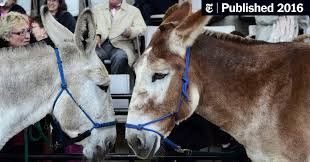

In [5]:
# Test
i = 1623
print(label_list[i])
animal_list[i]

### II. Convert Images to Vectors using ResNet18

In [6]:
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

In [7]:
class ImageProcess:
    def __init__(self):
        weights = ResNet18_Weights.DEFAULT
        self.model = resnet18(weights=weights)
        self.model = torch.nn.Sequential(*list(self.model.children()))[:-1]
        self.model.eval()
        
        self.transforms = transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=[0.485,0.456, 0.406], std=[0.229,0.224,0.225])])
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def get_embedding(self, image):
        img_tensor = self.transforms(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model(img_tensor).squeeze().cpu().numpy()
        return embedding

    def embed_list(self, image_list):
        embedded_list = []
        for img in image_list:
            embedded_list.append(self.get_embedding(img))
        embedded_list = np.vstack(embedded_list).astype('float32')
        return embedded_list

In [8]:
img_processor = ImageProcess()
img_vector_list = img_processor.embed_list(animal_list)
print(img_vector_list.shape)

(5400, 512)


### III. Prepare Training and Test Dataset

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_vector_list, label_list, test_size=0.2, stratify=label_list, random_state=1623)

### IV. Define FaissSearch Class

In [10]:
!pip install faiss-cpu

In [11]:
from collections import Counter
import faiss

class FaissSearch:
    def __init__(self):
        self.x_train = None
        self.y_train = None
        self.index = None

    def flat_search(self, training_dataset):
        self.x_train = np.array([x for x, y in training_dataset])
        self.y_train = [y for x, y in training_dataset]
        dim = self.x_train.shape[1]
        
        self.index = faiss.IndexFlatL2(dim)
        if not self.index.is_trained:
            self.index.train(self.x_train)

        self.index.add(self.x_train)
        return self.index

    def lsh_search(self, training_dataset, n):
        self.x_train = np.array([x for x, y in training_dataset])
        self.y_train = [y for x, y in training_dataset]
        dim = self.x_train.shape[1]

        self.index = faiss.IndexLSH(dim, dim*n)
        if not self.index.is_trained:
            self.index.train(self.x_train)

        self.index.add(self.x_train)
        return self.index

    def hnsw_search(self, training_dataset, M, ef_construction, ef_search):
        self.x_train = np.array([x for x, y in training_dataset])
        self.y_train = [y for x, y in training_dataset]
        dim = self.x_train.shape[1]

        self.index = faiss.IndexHNSWFlat(dim, M)
        self.index.hnsw.efconstruction = ef_construction
        self.index.hnsw.efsearch = ef_search
        if not self.index.is_trained:
            self.index.train(self.x_train)

        self.index.add(self.x_train)
        return self.index

    def search(self, query, k):
        D, I = self.index.search(np.array([query]), k)
        labels = [self.y_train[idx] for idx in I[0]]
        counter = Counter(labels)
        label = counter.most_common(1)[0][0]
        return label

In [12]:
%%time
# Quick Test
tr_dataset = list(zip(X_train, y_train))
j = 16

# Flat search
img_search_flat = FaissSearch()
index = img_search_flat.flat_search(tr_dataset)

detection = img_search_flat.search(X_test[j],10)
print('Flat Search:')
print('Detected animal:', detection)
print('Ground Truth:', y_test[j], '\n')

# LSH search
img_search_lsh = FaissSearch()
index = img_search_lsh.lsh_search(tr_dataset, 8)

detection = img_search_lsh.search(X_test[j],10)
print('LSH Search:')
print('Detected animal:', detection)
print('Ground Truth:', y_test[j], '\n')

# HNSW search
img_search_hnsw = FaissSearch()
index = img_search_hnsw.hnsw_search(tr_dataset, 16, 32,16)

detection = img_search_hnsw.search(X_test[j],10)
print('HNSW Search:')
print('Detected animal:', detection)
print('Ground Truth:', y_test[j], '\n')

Flat Search:
Detected animal: raccoon
Ground Truth: raccoon 

LSH Search:
Detected animal: raccoon
Ground Truth: raccoon 

HNSW Search:
Detected animal: raccoon
Ground Truth: raccoon 

CPU times: user 4.17 s, sys: 158 ms, total: 4.32 s
Wall time: 2.29 s


### V. Model Evaluation

In [13]:
# 10-fold cross validation
from sklearn.model_selection import StratifiedKFold

def eval_faiss(X, y, method:str, kwargs):
    skf = StratifiedKFold(n_splits=10)
    accuracy = []
    for tr_idx, ts_idx in skf.split(X, y):
        X_tr, y_tr = [X[i] for i in tr_idx], [y[i] for i in tr_idx]
        X_ts, y_ts = [X[i] for i in ts_idx], [y[i] for i in ts_idx]
    
        tr_dataset = list(zip(X_tr, y_tr))
        correct_detc = 0
        k = 10

        img_search = FaissSearch()
        if method=='flat':
            index = img_search.flat_search(tr_dataset)
        elif method=='lsh':
            n = kwargs.get('n')
            index = img_search.lsh_search(tr_dataset, n)
        elif method=='hnsw':
            M = kwargs.get('M')
            ef_construction = kwargs.get('ef_construction')
            ef_search = kwargs.get('ef_search')
            index = img_search.hnsw_search(tr_dataset, M, ef_construction, ef_search)
    
        for x_ts, y_ts in zip(X_test, y_test):
            correct_detc += 1 if img_search.search(x_ts, k)==y_ts else 0
        acc = correct_detc/len(y_test)
        accuracy += [acc]      
    
    print(f'Model accuracy: {np.array(accuracy).mean()*100:.2f}%')

In [14]:
kwargs = {'n': 8,
         'M': 16,
         'ef_construction': 32,
         'ef_search': 16}

In [15]:
%%time
# Flat Search
print('Flat Search:')
eval_faiss(img_vector_list, label_list, 'flat', kwargs)

Flat Search:
Model accuracy: 90.56%
CPU times: user 5.01 s, sys: 38.1 ms, total: 5.05 s
Wall time: 5.05 s


In [16]:
%%time
# LSH Search
print('LSH Search:')
eval_faiss(img_vector_list, label_list, 'lsh', kwargs)

LSH Search:
Model accuracy: 91.70%
CPU times: user 53.8 s, sys: 1.27 s, total: 55.1 s
Wall time: 27.8 s


In [17]:
%%time
# HNSW Search
print('HNSW Search:')
eval_faiss(img_vector_list, label_list, 'hnsw', kwargs)

HNSW Search:
Model accuracy: 90.31%
CPU times: user 3.69 s, sys: 12.9 ms, total: 3.7 s
Wall time: 2.09 s
